In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
import scipy
import os
import random
import shutil
# import joblib

In [2]:
train_folder = "E:/Mendeley Dataset/100x_datav2/train"
test_folder = "E:/Mendeley Dataset/100x_datav2/test"
validation_folder = "E:/Mendeley Dataset/100x_datav2/validate"

In [3]:
train_folder

'E:/Mendeley Dataset/100x_datav2/train'

In [4]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
validation_datagen= image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
test_datagen= image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'binary')
validation_generator = validation_datagen.flow_from_directory(
    validation_folder,
    target_size = (224,224),
    batch_size = 16,
    shuffle=True,
    class_mode = 'binary')
test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'binary')

Found 368 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


In [6]:
train_generator.class_indices

{'Normal': 0, 'OSCC': 1}

In [7]:
base_for_model = tf.keras.applications.VGG19(weights='imagenet', input_shape=(224,224,3), include_top=False)

80150528/80134624 [==============================] - 30s 0us/step


In [8]:
for layer in base_for_model.layers:
    layer.trainable = False

In [9]:
model = Sequential()
model.add(base_for_model) 
model.add(GaussianNoise(0.25)) #to prevent overfitting
model.add(GlobalAveragePooling2D()) #to converge and reduce the parameters
model.add(Dense(512, activation = 'relu')) #hidden layer (relu activation function is suggested for images)
model.add(BatchNormalization()) #to prevent overfitting
model.add(Dense(1, activation='sigmoid')) #output layer
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
gaussian_noise (GaussianNois (None, 7, 7, 512)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 20,289,601
Trainable params: 264,193
Non-trainable params: 20,025,408
______________________________________

In [10]:
adam= tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam,loss= 'binary_crossentropy', metrics=['accuracy','Precision','Recall','AUC'])

In [11]:
mp= tf.keras.callbacks.ModelCheckpoint(filepath='vgg19.hdf5',verbose=2, save_best_only=True)
es= tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.05, patience=3)
callback=[es,mp]

In [57]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9686404986799681717
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 881848320
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8861095484025836365
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [58]:
print(tf.test.is_gpu_available())

True


In [12]:
history = model.fit(
    train_generator,
#     steps_per_epoch= 4946/32,
    epochs = 10, #own choice
    validation_data = validation_generator,
    callbacks=callback
)

Epoch 1/10
23/23 [==============================] - 44s 2s/step - loss: 0.6624 - accuracy: 0.6196 - precision: 0.9064 - recall: 0.6033 - auc: 0.7564 - val_loss: 0.9676 - val_accuracy: 0.6250 - val_precision: 0.9556 - val_recall: 0.6056 - val_auc: 0.7879

Epoch 00001: val_loss improved from inf to 0.96762, saving model to vgg19.hdf5
Epoch 2/10
23/23 [==============================] - 41s 2s/step - loss: 0.4067 - accuracy: 0.8234 - precision: 0.9511 - recall: 0.8295 - auc: 0.8950 - val_loss: 0.4480 - val_accuracy: 0.8125 - val_precision: 0.9375 - val_recall: 0.8451 - val_auc: 0.7668

Epoch 00002: val_loss improved from 0.96762 to 0.44805, saving model to vgg19.hdf5
Epoch 3/10
23/23 [==============================] - 41s 2s/step - loss: 0.2840 - accuracy: 0.9103 - precision: 0.9722 - recall: 0.9180 - auc: 0.9497 - val_loss: 0.5111 - val_accuracy: 0.7875 - val_precision: 0.9500 - val_recall: 0.8028 - val_auc: 0.7919

Epoch 00003: val_loss did not improve from 0.44805
Epoch 4/10
23/23 [====

In [13]:
print(history.history.keys())
acc=(history.history['accuracy'])
loss=(history.history['loss'])
prc=(history.history['precision'])
rec=(history.history['recall'])
auc=(history.history['auc'])
val_acc=(history.history['val_accuracy'])
val_loss=(history.history['val_loss'])
val_prc=(history.history['val_precision'])
val_rec=(history.history['val_recall'])
val_auc=(history.history['val_auc'])

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


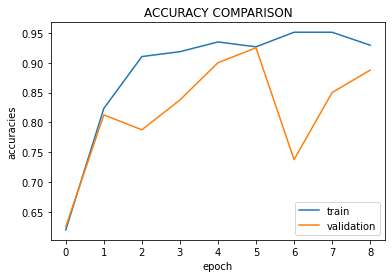

In [14]:
plt.plot(acc)
plt.plot(val_acc)
plt.title('ACCURACY COMPARISON')
plt.xlabel('epoch')
plt.ylabel('accuracies')
plt.title('ACCURACY COMPARISON')
plt.legend(['train','validation'])

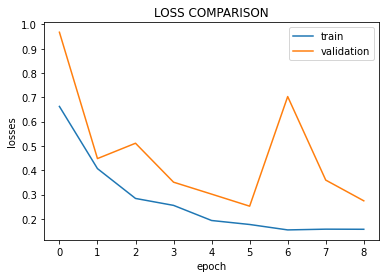

In [15]:
plt.title('LOSS COMPARISON')
plt.plot(loss)
plt.plot(val_loss)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['train','validation'])

In [16]:
print("Model Train Evaluation")
model.evaluate(train_generator)
print("Model Validation Evaluation")
model.evaluate(validation_generator)
print("Model Test Evaluation")
model.evaluate(test_generator)

Model Train Evaluation
23/23 [==============================] - 34s 1s/step - loss: 0.1470 - accuracy: 0.9429 - precision: 0.9863 - recall: 0.9443 - auc: 0.9893
Model Validation Evaluation
5/5 [==============================] - 8s 1s/step - loss: 0.3453 - accuracy: 0.8625 - precision: 0.9545 - recall: 0.8873 - auc: 0.8365
Model Test Evaluation
5/5 [==============================] - 8s 1s/step - loss: 0.5441 - accuracy: 0.8228 - precision: 0.9138 - recall: 0.8548 - auc: 0.8463


[0.5441103577613831,
 0.8227847814559937,
 0.9137930870056152,
 0.8548387289047241,
 0.8462998270988464]

In [ ]:
img =(image.load_img('D:/Research/Oral Cancer Detection/Data/Mendeley Data/First Set/100x Normal Oral Cavity Histopathological Images/Normal_100x_12.jpg',target_size=(224,224)))
imaga = image.img_to_array(img)
image = np.expand_dims(imaga,axis=0)  
ypred = model.predict(image)
if ypred<0.5:
      ypred="Normal"
else:
      ypred="Squamous Cell Carcinoma" 
plt.imshow(img)
ypred

In [17]:
model.save("vgg19.h5")
print("Saved model to disk")

Saved model to disk
